# **1. Installing Library**


In [1]:
# !pip install xgboost
!pip install bayesian-optimization

# **2. Import Library**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime,timedelta
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer


# **3. Load Dataset**


In [3]:
df = pd.read_csv('dataset\irradiance_dataset')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\1717908015.py:1: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv('dataset\irradiance_dataset')


,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False


# **4. Exploratory Data Analysis (EDA)**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ALLSKY_SFC_SW_DWN     20544 non-null  float64
 1   PS                    20544 non-null  float64
 2   QV2M                  20544 non-null  float64
 3   T2M                   20544 non-null  float64
 4   time                  20544 non-null  int64  
 5   hour                  20544 non-null  int64  
 6   dayofweek             20544 non-null  int64  
 7   quarter               20544 non-null  int64  
 8   month                 20544 non-null  int64  
 9   year                  20544 non-null  int64  
 10  dayofyear             20544 non-null  int64  
 11  cluster               20544 non-null  int64  
 12  distance_to_centroid  20544 non-null  float64
 13  is_outlier            20544 non-null  bool   
dtypes: bool(1), float64(5), int64(8)
memory usage: 2.1 MB


In [5]:
df['datetime'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
df.head()

,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier,datetime
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False,2022-03-27 00:00:00
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False,2022-03-27 01:00:00
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False,2022-03-27 02:00:00
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False,2022-03-27 03:00:00
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False,2022-03-27 04:00:00


In [6]:
new_df = df[['datetime','ALLSKY_SFC_SW_DWN']]
new_df = new_df.set_index('datetime')
new_df.head()

,ALLSKY_SFC_SW_DWN
datetime,
2022-03-27 00:00:00,0.0
2022-03-27 01:00:00,0.0
2022-03-27 02:00:00,0.0
2022-03-27 03:00:00,0.0
2022-03-27 04:00:00,0.0


<Axes: xlabel='datetime'>

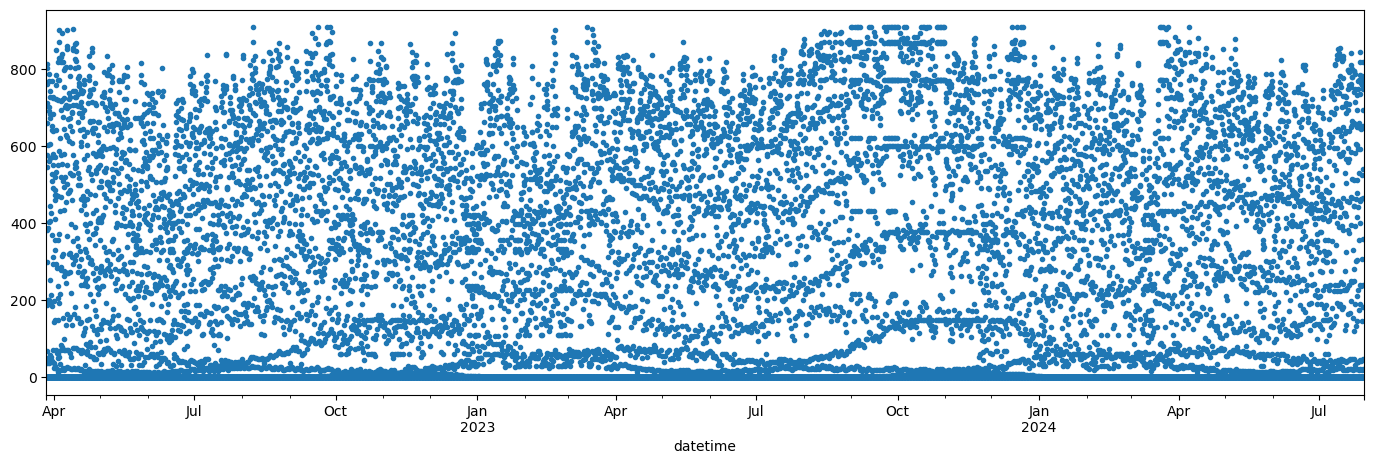

In [7]:
new_df['ALLSKY_SFC_SW_DWN'].plot(style='.', figsize=(17,5))


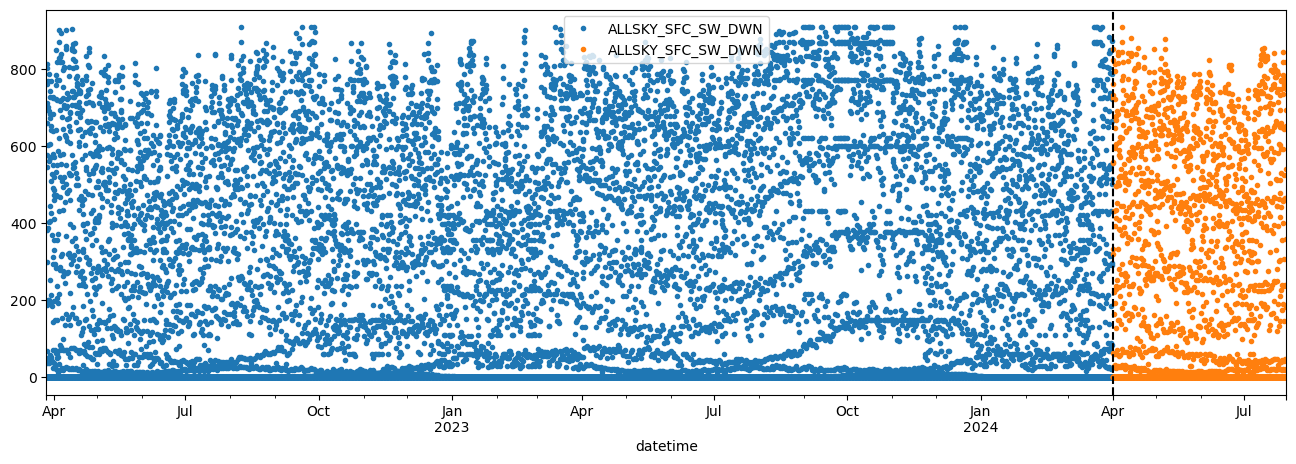

In [8]:
train = new_df.loc[new_df.index < '04-01-2024']
test = new_df.loc[new_df.index >= '04-01-2024']

fig, ax = plt.subplots(figsize=(16,5))
train.plot(ax=ax , label='train',style='.')
test.plot(ax=ax, label='test',style='.')
ax.axvline('04-01-2024',color='black',ls='--')
plt.show()

In [9]:
def create_features(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df

In [10]:
data_df = create_features(new_df)
data_df.head()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,quarter,month,year,dayofyear
datetime,,,,,,,
2022-03-27 00:00:00,0.0,0,6,1,3,2022,86
2022-03-27 01:00:00,0.0,1,6,1,3,2022,86
2022-03-27 02:00:00,0.0,2,6,1,3,2022,86
2022-03-27 03:00:00,0.0,3,6,1,3,2022,86
2022-03-27 04:00:00,0.0,4,6,1,3,2022,86


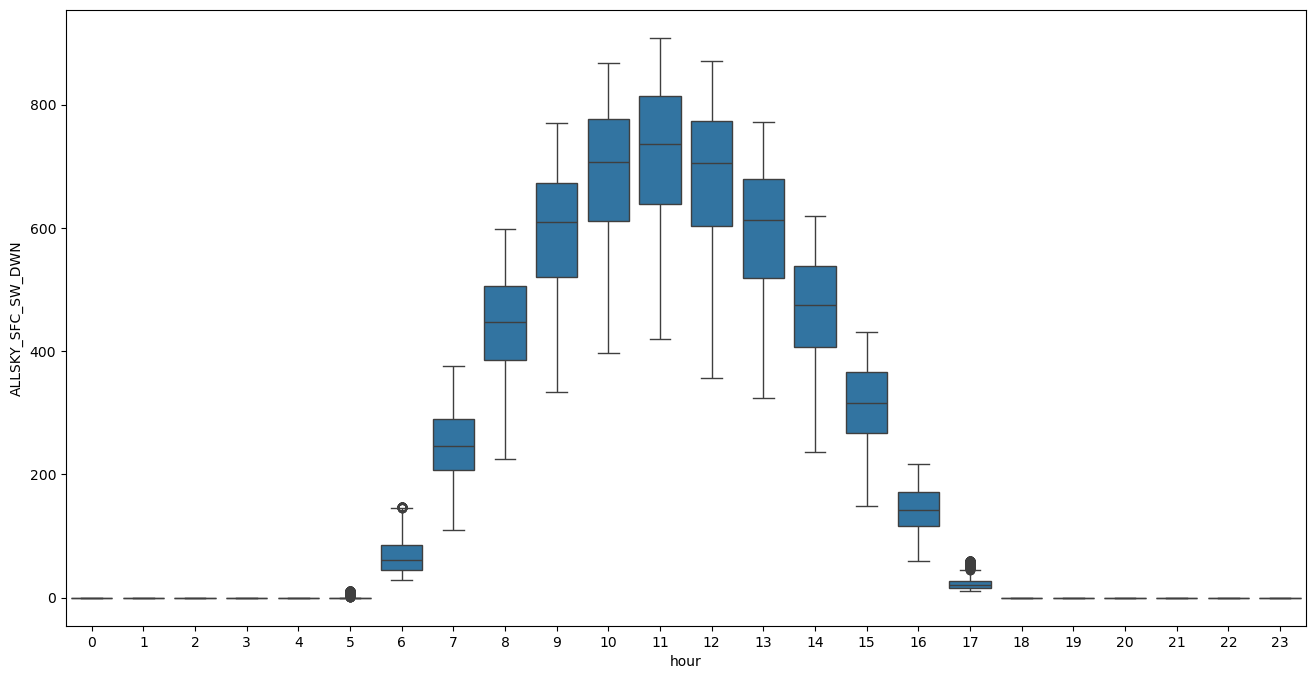

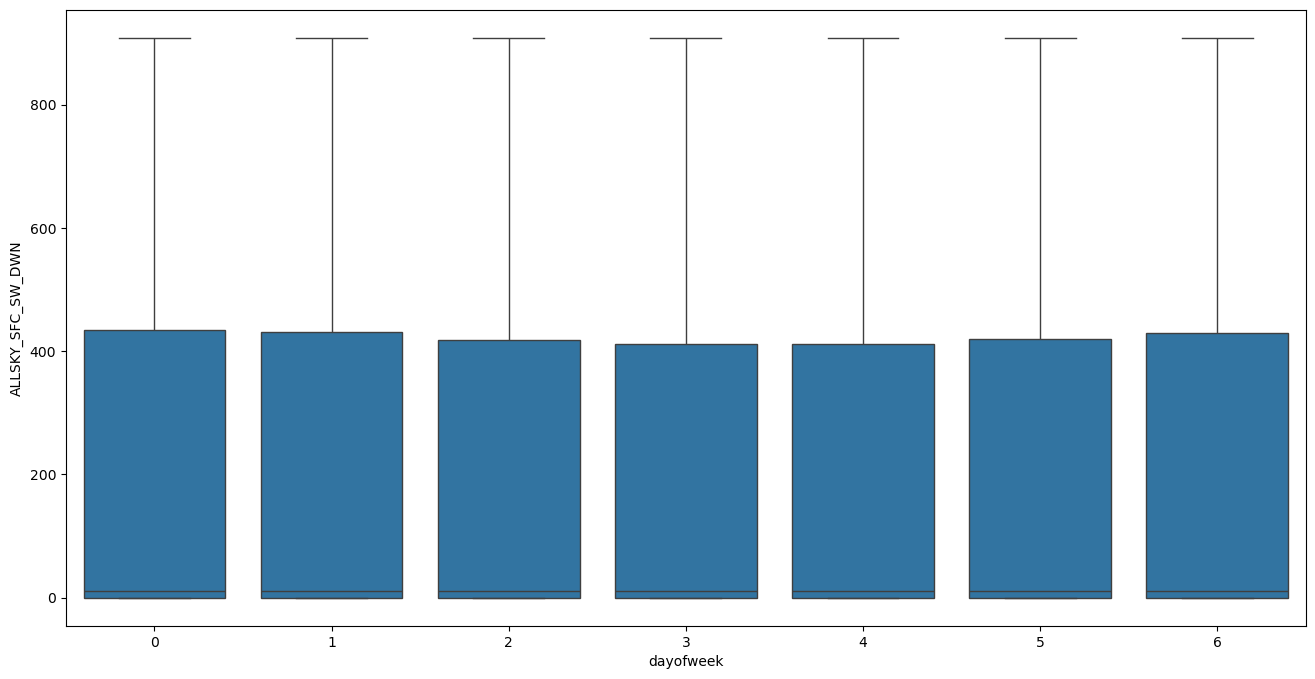

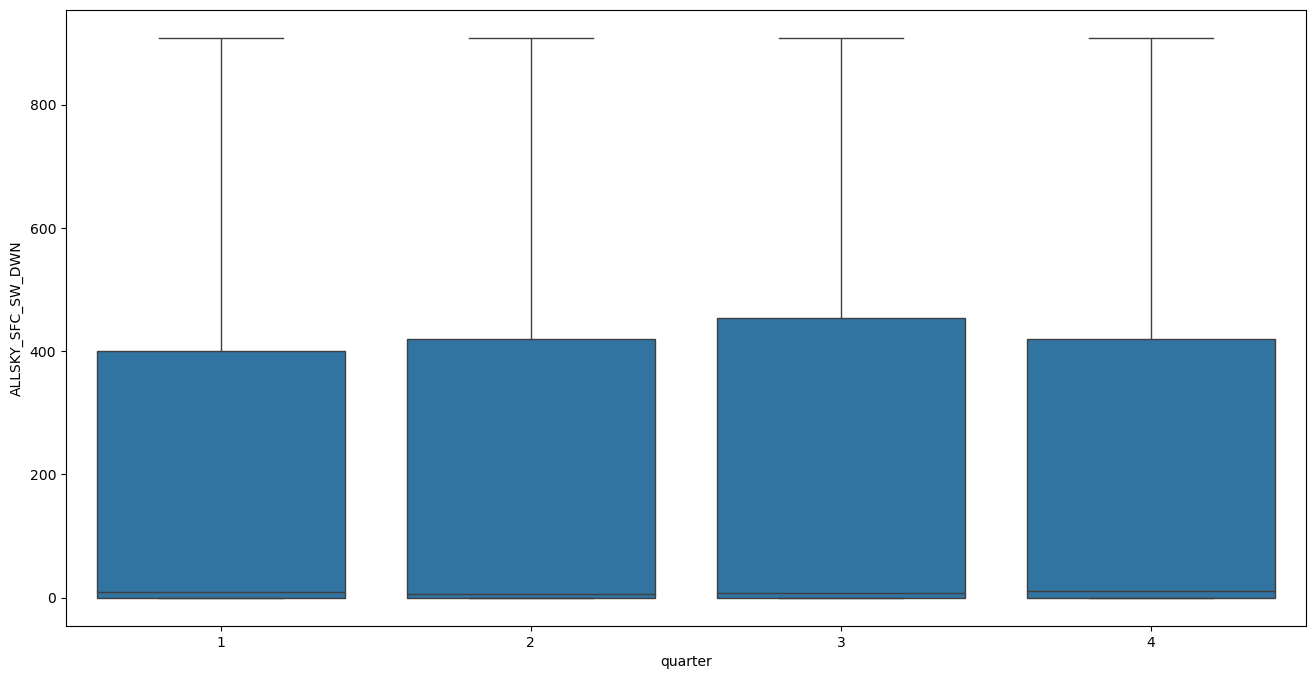

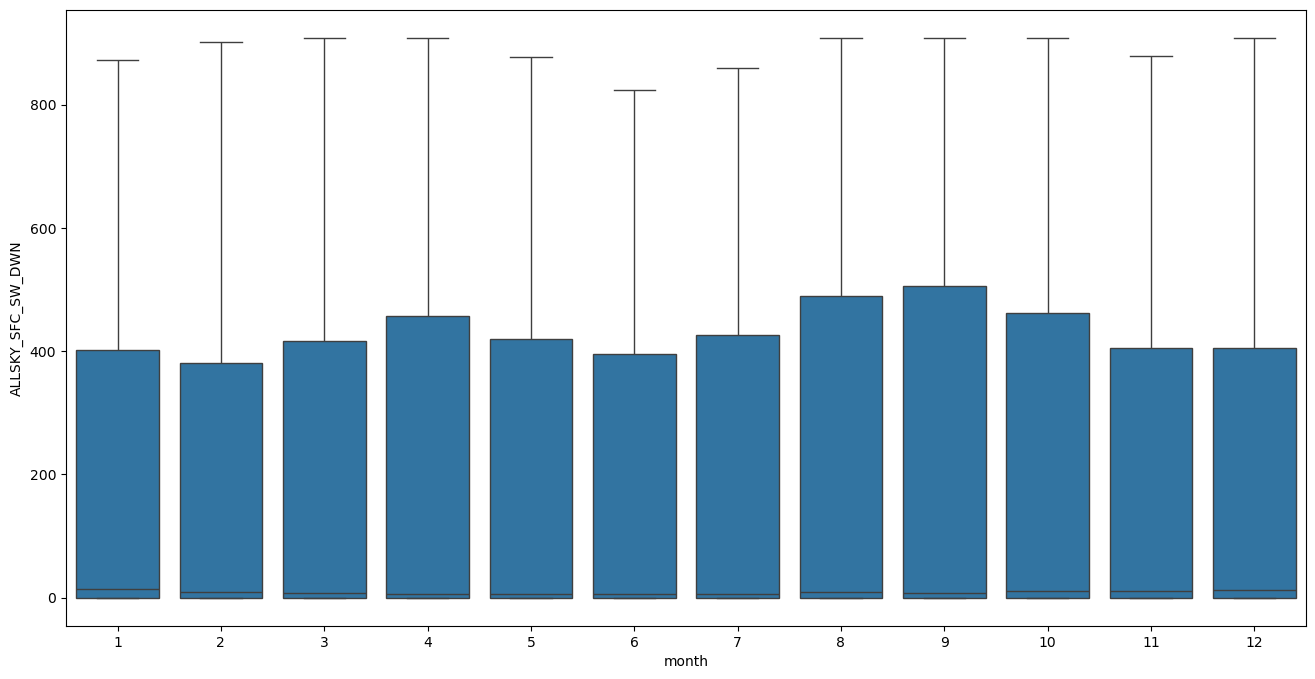

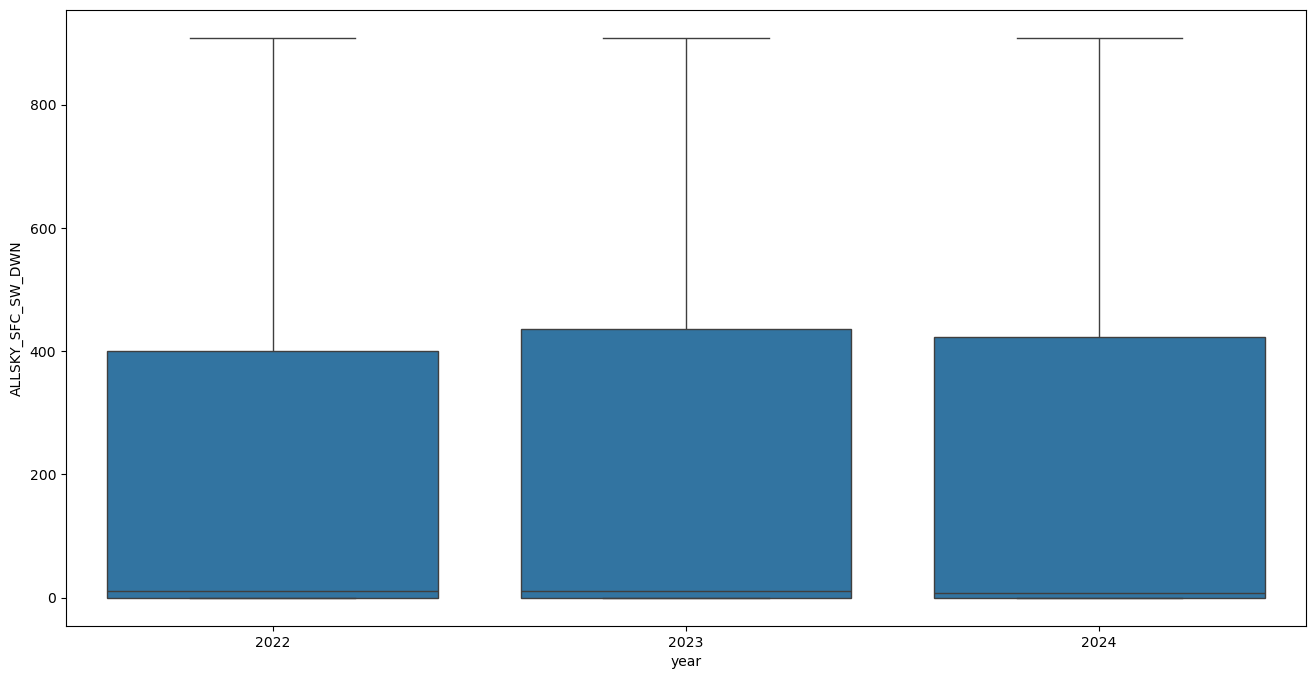

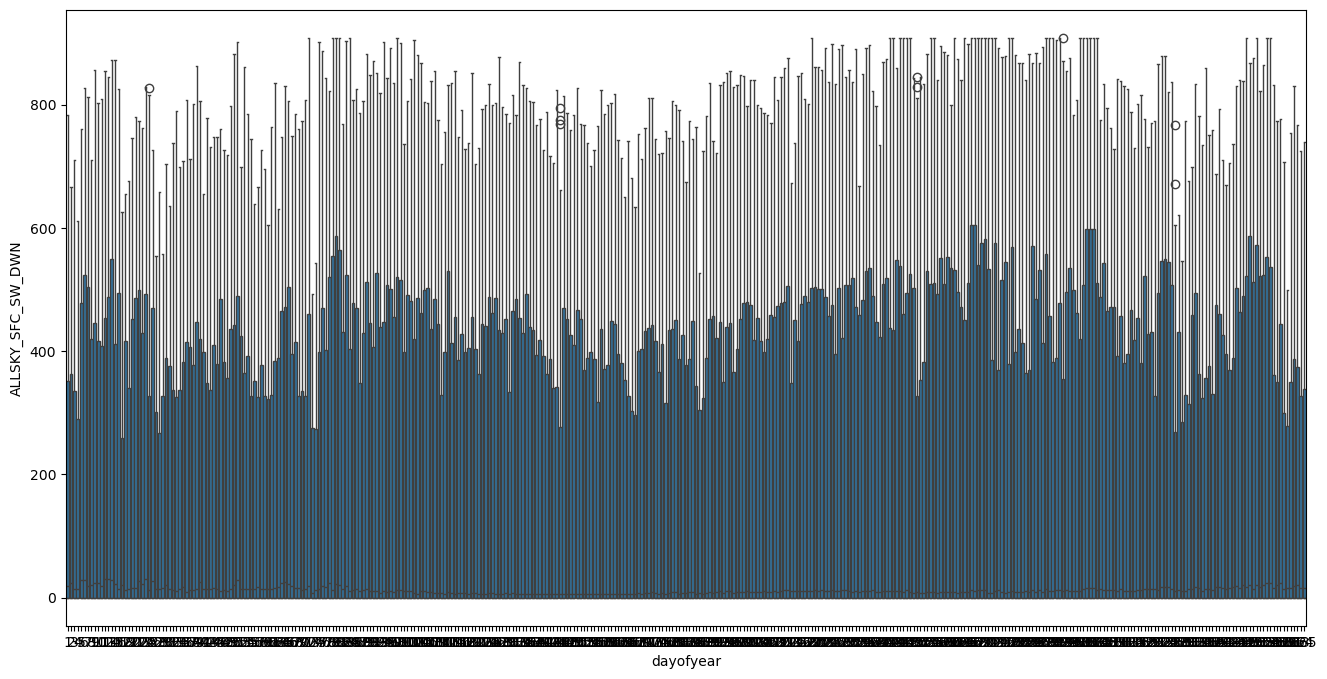

In [11]:
column = ['hour','dayofweek','quarter','month','year','dayofyear']
for i in column:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.boxplot(data=data_df, x =i,y='ALLSKY_SFC_SW_DWN')
  plt.show()

# **5. Building Regresion Model**

In [12]:
train = create_features(train)
test = create_features(test)

C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\1483320389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\1483320389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\1483320389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [13]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'ALLSKY_SFC_SW_DWN'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
y_pred = reg.predict(x_test)
y_pred

array([8.215031, 8.215031, 8.215031, ..., 6.67795 , 6.67795 , 6.67795 ],
      dtype=float32)

In [16]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 2856.935816917734
R-squared: 0.9609680710520689


# **6. Hyperparameter Using BayesSearch**

In [17]:
search_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'subsample': Real(0.5, 1.0),
    'max_features': Real(0.5, 1.0)
}

gbr_opt = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=search_space,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Training
gbr_opt.fit(x_train, y_train)
print(gbr_opt.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04404550102251715, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_features=0.5,
             max_leaves=None, min_child_weight=None, min_samples_leaf=20,
             min_samples_split=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, ...)


e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:09:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
y_pred_bayes = gbr_opt.predict(x_test)
y_pred_bayes

array([7.05384  , 7.05384  , 7.05384  , ..., 6.7675595, 6.7675595,
       6.7675595], dtype=float32)

In [19]:
bayes_mse = mean_squared_error(y_test, y_pred_bayes)
bayes_r2 = r2_score(y_test, y_pred_bayes)

print('Mean Squared Error:', bayes_mse)
print('R-squared:', bayes_r2)

Mean Squared Error: 2862.113585059038
R-squared: 0.9608973315286244


In [20]:
test['prediction1'] = y_pred
test['prediction_beyes'] = y_pred_bayes
last_df = new_df.merge(test['prediction1'], how='left', left_index=True, right_index=True)
last_df = last_df.merge(test['prediction_beyes'], how='left', left_index=True, right_index=True)
last_df.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\3310411478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction1'] = y_pred
C:\Users\Acer\AppData\Local\Temp\ipykernel_2348\3310411478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_beyes'] = y_pred_bayes


,ALLSKY_SFC_SW_DWN,hour,dayofweek,quarter,month,year,dayofyear,prediction1,prediction_beyes
datetime,,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,1,3,2022,86,NaN,NaN
2022-03-27 01:00:00,0.0,1,6,1,3,2022,86,NaN,NaN
2022-03-27 02:00:00,0.0,2,6,1,3,2022,86,NaN,NaN
2022-03-27 03:00:00,0.0,3,6,1,3,2022,86,NaN,NaN
2022-03-27 04:00:00,0.0,4,6,1,3,2022,86,NaN,NaN


# **7. compare models before and after hyperparameters**

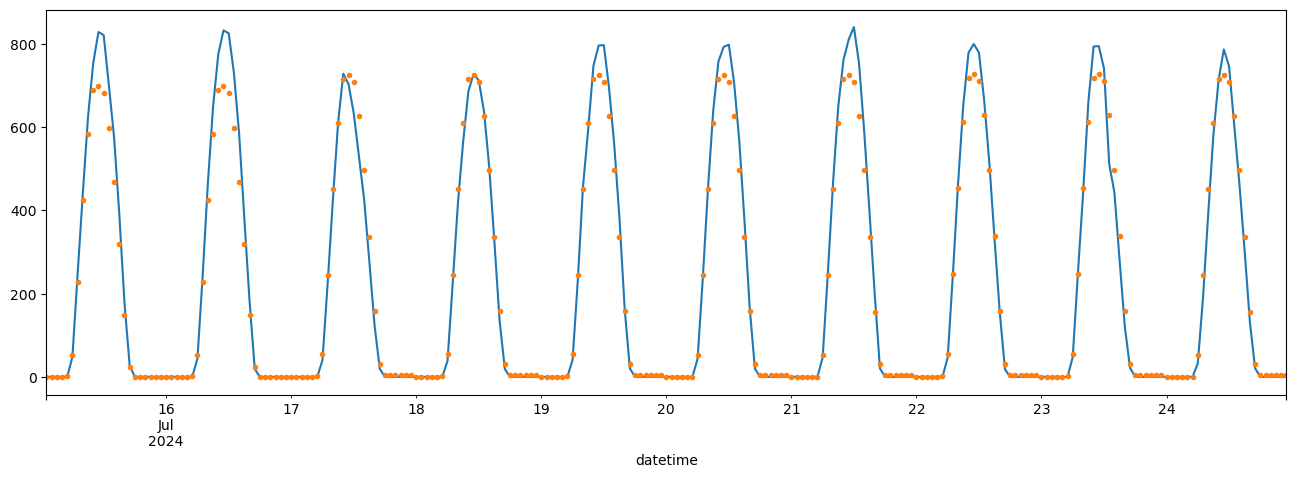

In [21]:
ax = last_df.loc[(last_df.index > '07-15-2024') & (last_df.index < '07-25-2024')]['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df.loc[(last_df.index > '07-15-2024') & (last_df.index < '07-25-2024')]['prediction1'].plot(ax=ax, style='.')
plt.show()

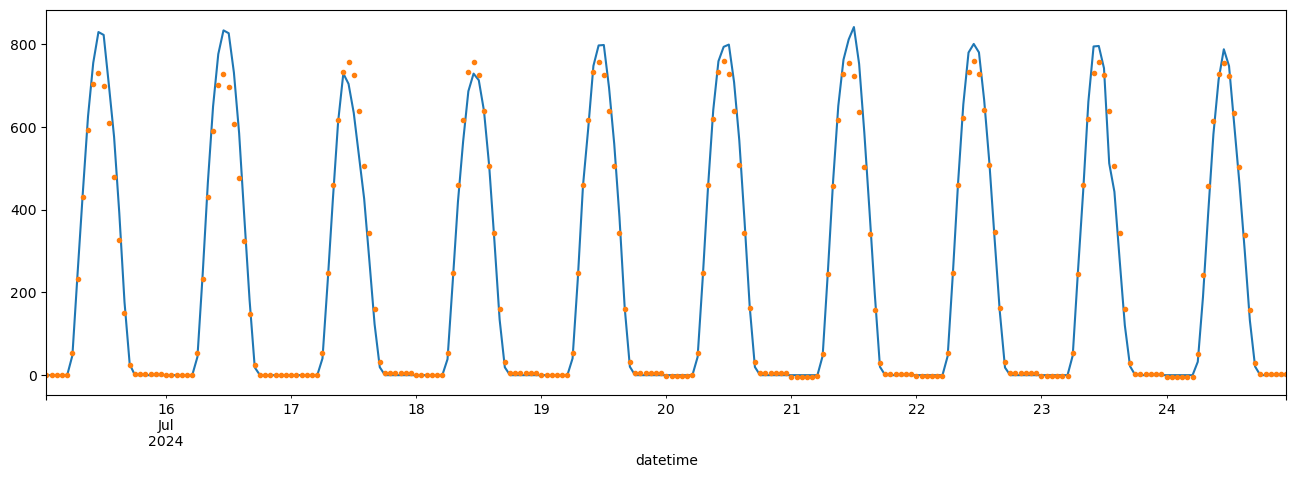

In [22]:
ax = last_df.loc[(last_df.index > '07-15-2024') & (last_df.index < '07-25-2024')]['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df.loc[(last_df.index > '07-15-2024') & (last_df.index < '07-25-2024')]['prediction_beyes'].plot(ax=ax, style='.')
plt.show()

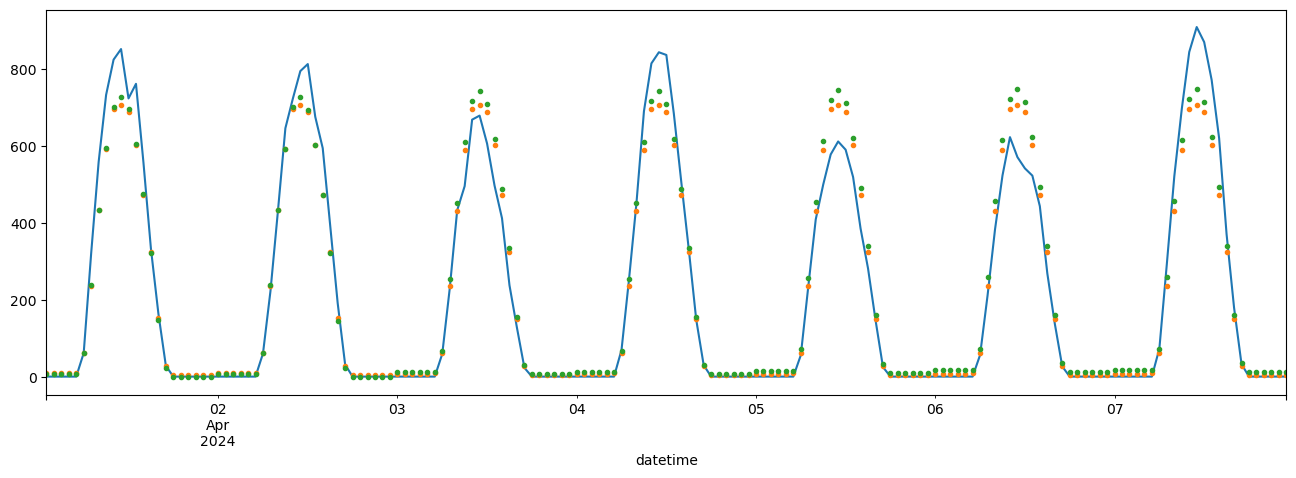

In [23]:
ax = last_df.loc[(last_df.index > '04-01-2024') & (last_df.index < '04-08-2024')]['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df.loc[(last_df.index > '04-01-2024') & (last_df.index < '04-08-2024')]['prediction1'].plot(ax=ax, style='.')
last_df.loc[(last_df.index > '04-01-2024') & (last_df.index < '04-08-2024')]['prediction_beyes'].plot(ax=ax, style='.')
plt.show()

In [24]:
last_df[last_df.prediction1 < 0].count()

ALLSKY_SFC_SW_DWN    603
hour                 603
dayofweek            603
quarter              603
month                603
year                 603
dayofyear            603
prediction1          603
prediction_beyes     603
dtype: int64

In [30]:
last_df[last_df.prediction1 >= 0].count()

ALLSKY_SFC_SW_DWN    2277
hour                 2277
dayofweek            2277
quarter              2277
month                2277
year                 2277
dayofyear            2277
prediction1          2277
prediction_beyes     2277
dtype: int64

In [25]:
last_df[last_df.prediction_beyes < 0].count()

ALLSKY_SFC_SW_DWN    728
hour                 728
dayofweek            728
quarter              728
month                728
year                 728
dayofyear            728
prediction1          728
prediction_beyes     728
dtype: int64

In [28]:
last_df[last_df.prediction_beyes >= 0].count()

ALLSKY_SFC_SW_DWN    2152
hour                 2152
dayofweek            2152
quarter              2152
month                2152
year                 2152
dayofyear            2152
prediction1          2152
prediction_beyes     2152
dtype: int64

# **8. Saving Model Evaluation**

In [ ]:
import csv

In [ ]:
file = pd.read_csv('Evaluation_Model_Score')
file

,model,r2_score,Mean Squared Error
0,Randomforest,0.926070,5307.576827
1,Randomforest BayesSearchCV,0.942100,4156.782188
2,GradientBoosting,0.945029,3946.439377
3,GradientBoosting BayesSearchCV,0.945373,3921.785175


In [ ]:
fields=['Xgboost',r2,mse]
fields2=['Xgboost BayesSearchCV',bayes_r2,bayes_mse]

with open('Evaluation_Model_Score', mode='a',newline='') as file :
    writter=csv.writer(file)
    writter.writerow(fields)
    writter.writerow(fields2)

In [ ]:
file = pd.read_csv('Evaluation_Model_Score')
file

,model,r2_score,Mean Squared Error
0,Randomforest,0.926070,5307.576827
1,Randomforest BayesSearchCV,0.942100,4156.782188
2,GradientBoosting,0.945029,3946.439377
3,GradientBoosting BayesSearchCV,0.945373,3921.785175
4,Xgboost,0.960968,2856.935817
5,Xgboost BayesSearchCV,0.960897,2862.113585
